In [2]:
!pip install tensorflow==2.20.0 pillow numpy opencv-python matplotlib captcha

  Using cached tensorflow-2.20.0-cp312-cp312-win_amd64.whl.metadata (4.6 kB)
  Using cached captcha-0.7.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached numpy-2.2.6-cp312-cp312-win_amd64.whl.metadata (60 kB)
Using cached tensorflow-2.20.0-cp312-cp312-win_amd64.whl (331.9 MB)
Using cached numpy-2.2.6-cp312-cp312-win_amd64.whl (12.6 MB)
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   ------------------------------------

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\Lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\Users\HP\anaconda3\Lib\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\HP\anaconda3\Lib\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\HP\anaconda3\Lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 98, in read
    data: bytes = self.__fp.read(amt)
                  ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\HP\anaconda3\Lib\http\client.py", line 479, in read
    s = self.fp.read(amt)
        ^^^^^^^^^^^^^^^^^
  File "C:\Users\HP\anaconda3\Lib\socket.py", line 720, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^

In [7]:
!pip install tensorflow==2.20.0 --default-timeout=200 -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [9]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Is GPU available?", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.20.0
Is GPU available? []


In [20]:
import os
import random
import shutil

# Correct full paths
base_dir = r'downloads/college/sem5/ML_mini/captcha_solver/dataset'
source_dir = os.path.join(base_dir, 'samples')
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Create train/test folders if not exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get all image file names
all_images = [f for f in os.listdir(source_dir) if f.endswith('.png')]
random.shuffle(all_images)

# Split: 80% train, 20% test
split_index = int(0.8 * len(all_images))
train_files = all_images[:split_index]
test_files = all_images[split_index:]

# Move files
for f in train_files:
    shutil.copy(os.path.join(source_dir, f), os.path.join(train_dir, f))

for f in test_files:
    shutil.copy(os.path.join(source_dir, f), os.path.join(test_dir, f))

print(f"Moved {len(train_files)} images to train and {len(test_files)} images to test.")

Moved 832 images to train and 208 images to test.


Synthetic CAPTCHA Generation

In [24]:
!pip install captcha

  Using cached captcha-0.7.1-py3-none-any.whl.metadata (2.2 kB)
Using cached captcha-0.7.1-py3-none-any.whl (147 kB)


In [26]:
# Install captcha if not already
# pip install captcha

from captcha.image import ImageCaptcha
import random
import string
import os

output_dir = r'downloads/college/sem5/ML_mini/captcha_solver/dataset/train_synthetic'
os.makedirs(output_dir, exist_ok=True)

characters = string.ascii_letters + string.digits
n_samples = 500  # number of synthetic captchas to generate
captcha_length = 5
img_width = 200
img_height = 50

image = ImageCaptcha(width=img_width, height=img_height)

for i in range(n_samples):
    captcha_text = ''.join(random.choices(characters, k=captcha_length))
    filename = f"{captcha_text}_{i}.png"
    image.write(captcha_text, os.path.join(output_dir, filename))

print(f"{n_samples} synthetic captcha images generated!")


500 synthetic captcha images generated!


INTEGRATION

In [29]:
import shutil

synthetic_dir = output_dir
train_dir = r'downloads/college/sem5/ML_mini/captcha_solver/dataset/train'

for f in os.listdir(synthetic_dir):
    shutil.move(os.path.join(synthetic_dir, f), train_dir)

print("Synthetic data merged with original training data")

Synthetic data merged with original training data


PREPROCESSING

In [100]:
import os
import numpy as np
import cv2
import random
from sklearn.preprocessing import LabelBinarizer

# ---------------- PARAMETERS ----------------
img_width, img_height = 128, 64
captcha_length = 5  # adjust to your dataset
characters = '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'  # all chars

# Initialize LabelBinarizer
lb = LabelBinarizer()
lb.fit(list(characters))  # preserve order of characters
classes = lb.classes_  # use this for decoding later

# ---------------- FUNCTIONS ----------------
def encode_label(text, lb=lb, max_length=captcha_length):
    """
    Convert captcha text (before underscore) to one-hot encoding.
    Case-sensitive.
    """
    text = text.split('_')[0]  # take only part before '_'
    length = min(len(text), max_length)
    encoded = np.zeros((max_length, len(lb.classes_)), dtype=np.float32)
    for i in range(length):
        encoded[i] = lb.transform([text[i]])
    return encoded

def load_data(directory):
    images = []
    labels = []
    all_files = [f for f in os.listdir(directory) if f.endswith('.png')]
    
    for file in all_files:
        # Read and normalize image
        img_path = os.path.join(directory, file)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (img_width, img_height))
        image = image.astype('float32') / 255.0
        image = np.expand_dims(image, axis=-1)
        images.append(image)
        
        # Encode label
        label_text = os.path.splitext(file)[0]
        labels.append(encode_label(label_text))
    
    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='float32')
    
    # Shuffle
    c = list(zip(images, labels))
    random.shuffle(c)
    images, labels = zip(*c)
    
    return np.array(images), np.array(labels)

# ---------------- LOAD DATA ----------------
train_dir = "downloads/college/sem5/ML_mini/captcha_solver/dataset/train"
test_dir  = "downloads/college/sem5/ML_mini/captcha_solver/dataset/test"

X_train, y_train = load_data(train_dir)
X_test, y_test = load_data(test_dir)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)
print("Label classes:", classes)

Train shape: (1505, 64, 128, 1) (1505, 5, 62)
Test shape: (381, 64, 128, 1) (381, 5, 62)
Label classes: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


CNN Model

In [102]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape

num_chars = captcha_length
num_classes = len(classes)

def build_cnn_model():
    model = Sequential()

    # Conv layers
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(img_height, img_width,1)))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2)))
    
    # Flatten + Dense
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_chars*num_classes, activation='softmax'))
    model.add(Reshape((num_chars, num_classes)))  # reshape to (num_chars, num_classes)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

cnn_model = build_cnn_model()
cnn_model.summary()

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 64, 128, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 32, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 32, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 16, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 16, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 8, 16, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1024)                │      16,778,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 310)                 │         317,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_8 (Reshape)                  │ (None, 5, 62)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,188,662 (65.57 MB)

 Trainable params: 17,188,662 (65.57 MB)

 Non-trainable params: 0 (0.00 B)

TRAIN THE MODEL

In [151]:
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=20
)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 357ms/step - accuracy: 0.9637 - loss: 0.1002 - val_accuracy: 0.9864 - val_loss: 0.0488
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.9682 - loss: 0.1036 - val_accuracy: 0.9864 - val_loss: 0.0531
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 354ms/step - accuracy: 0.9721 - loss: 0.0932 - val_accuracy: 0.9879 - val_loss: 0.0526
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 357ms/step - accuracy: 0.9742 - loss: 0.0889 - val_accuracy: 0.9879 - val_loss: 0.0538
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 360ms/step - accuracy: 0.9737 - loss: 0.0871 - val_accuracy: 0.9864 - val_loss: 0.0615
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 355ms/step - accuracy: 0.9762 - loss: 0.0771 - val_accuracy: 0.9879 - val_loss: 0.0518
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 361ms/step - accuracy: 0.9751 - loss: 0.0756 - val_accuracy: 0.9885 - val_loss: 0.0492
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 359ms/step - accuracy: 0.9742 - loss: 0.0814 - val_accu

In [155]:
cnn_model.save("captcha_cnn_model.h5")
print("Model saved as captcha_cnn_model.h5")

Model saved as captcha_cnn_model.h5


In [157]:
cnn_model.save("captcha_cnn_model.keras")
print("Model saved as captcha_cnn_model.keras")

Model saved as captcha_cnn_model.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


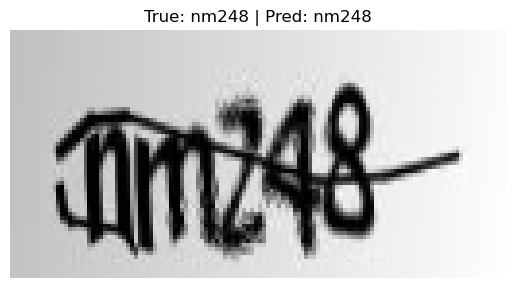

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


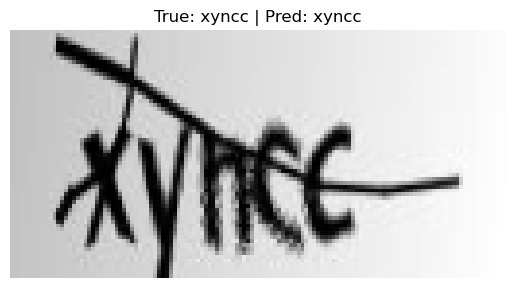

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


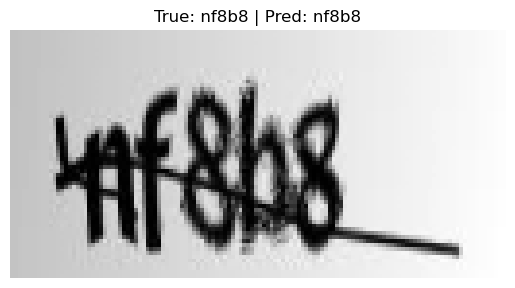

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


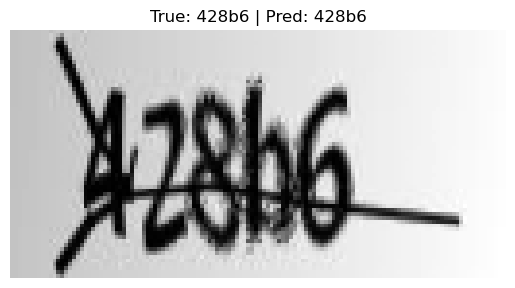

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


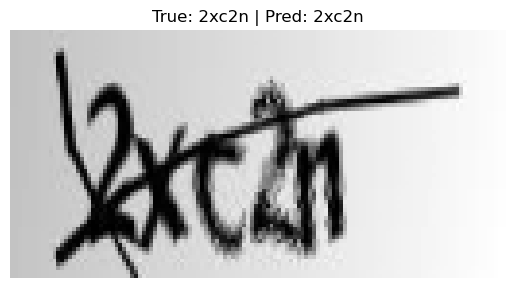

In [113]:
import matplotlib.pyplot as plt

def decode_prediction(pred):
    """Use LabelBinarizer classes to decode, preserving case."""
    text = ""
    for i in range(pred.shape[0]):
        char_index = np.argmax(pred[i])
        text += classes[char_index]
    return text

# Test a few samples
num_samples = 5
sample_indices = np.random.choice(len(X_test), num_samples, replace=False)

for idx in sample_indices:
    image = X_test[idx]
    true_label = decode_prediction(y_test[idx])
    
    pred = cnn_model.predict(image.reshape(1, img_height, img_width, 1))
    pred_text = decode_prediction(pred[0])
    
    plt.imshow(image.reshape(img_height, img_width), cmap='gray')
    plt.title(f"True: {true_label} | Pred: {pred_text}")
    plt.axis('off')
    plt.show()

In [85]:
import os

for f in os.listdir(train_dir)[:20]:
    print(f)

07lTW_215.png
0m4oO_163.png
0tf3j_198.png
0U222_475.png
12WOY_95.png
13bxA_358.png
14F4U_179.png
17KXO_293.png
1iQDV_157.png
1JR9h_469.png
1L7yi_31.png
1O7JI_63.png
1QDz6_440.png
1VDd6_365.png
1zHfA_94.png
226md.png
22d5n.png
2356g.png
23mdg.png
23n88.png


Preprocessing for CNN + Bi LSTM

CNN + BiLSTM Model

CTC Loss

In [143]:
import os
import numpy as np
import cv2
import random
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Dense, Dropout, Bidirectional, LSTM, Lambda
from tensorflow.keras import backend as K
from sklearn.preprocessing import LabelBinarizer

# ------------------------ PARAMETERS ------------------------
img_width, img_height = 128, 64
captcha_length = 5  # number of characters in captcha
characters = '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
num_classes = len(characters) + 1  # +1 for CTC blank

# Initialize LabelBinarizer
lb = LabelBinarizer()
lb.fit(list(characters))

# ------------------------ FUNCTIONS ------------------------
def encode_label(text, lb=lb, max_length=captcha_length):
    text = text.split('_')[0]
    length = min(len(text), max_length)
    encoded = np.zeros((max_length, len(lb.classes_)))
    for i in range(length):
        encoded[i] = lb.transform([text[i]])
    return encoded

def load_data(directory):
    images, labels = [], []
    files = [f for f in os.listdir(directory) if f.endswith('.png')]
    for file in files:
        # image
        img_path = os.path.join(directory, file)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (img_width, img_height))
        image = image.astype('float32') / 255.0
        image = np.expand_dims(image, axis=-1)
        images.append(image)

        # label
        label_text = os.path.splitext(file)[0]
        labels.append(encode_label(label_text))
    
    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='float32')
    
    # shuffle
    c = list(zip(images, labels))
    random.shuffle(c)
    images, labels = zip(*c)
    return np.array(images), np.array(labels)

# ------------------------ LOAD DATA ------------------------
train_dir = "downloads/college/sem5/ML_mini/captcha_solver/dataset/train"
test_dir  = "downloads/college/sem5/ML_mini/captcha_solver/dataset/test"

X_train, y_train = load_data(train_dir)
X_test, y_test   = load_data(test_dir)

# Convert one-hot to integer labels for CTC
y_train_int = np.argmax(y_train, axis=-1)
y_test_int  = np.argmax(y_test, axis=-1)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

# ------------------------ MODEL ------------------------
inputs = Input(shape=(img_height, img_width, 1), name='input_image')

# CNN
x = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)

# Determine time steps dynamically
shape = tf.keras.backend.int_shape(x)  # (batch, h, w, c)
time_steps = shape[2]  # width
features_per_step = shape[1] * shape[3]  # height * channels

# Reshape for LSTM
x = Reshape((time_steps, features_per_step))(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)

# Dense output
x = Dense(num_classes, activation='softmax')(x)

# Labels and lengths
labels = Input(name='labels', shape=(captcha_length,), dtype='int32')
input_length = Input(name='input_length', shape=(1,), dtype='int32')
label_length = Input(name='label_length', shape=(1,), dtype='int32')

# CTC loss lambda
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
    [x, labels, input_length, label_length])

# Model
ctc_model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)
ctc_model.compile(optimizer='adam', loss={'ctc': lambda y_true, y_pred: y_pred})

# ------------------------ INPUT LENGTHS ------------------------
train_input_len = np.ones((X_train.shape[0], 1)) * time_steps
train_label_len = np.ones((X_train.shape[0], 1)) * captcha_length

test_input_len = np.ones((X_test.shape[0], 1)) * time_steps
test_label_len = np.ones((X_test.shape[0], 1)) * captcha_length

train_inputs = {
    'input_image': X_train,
    'labels': y_train_int,
    'input_length': train_input_len,
    'label_length': train_label_len
}
test_inputs = {
    'input_image': X_test,
    'labels': y_test_int,
    'input_length': test_input_len,
    'label_length': test_label_len
}

train_outputs = np.zeros((X_train.shape[0], 1))
test_outputs  = np.zeros((X_test.shape[0], 1))

# ------------------------ TRAIN ------------------------
history = ctc_model.fit(
    train_inputs,
    train_outputs,
    validation_data=(test_inputs, test_outputs),
    batch_size=32,
    epochs=50
)

Train shape: (1505, 64, 128, 1) (1505, 5, 62)
Test shape: (381, 64, 128, 1) (381, 5, 62)
Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 399ms/step - loss: 21.9206 - val_loss: 17.4343
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 18s 345ms/step - loss: 19.9528 - val_loss: 17.3946
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 393ms/step - loss: 19.9334 - val_loss: 17.7425
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 18s 345ms/step - loss: 19.8453 - val_loss: 17.1789
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 344ms/step - loss: 18.6388 - val_loss: 16.3416
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 353ms/step - loss: 18.2561 - val_loss: 16.0937
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 341ms/step - loss: 18.0339 - val_loss: 15.9638
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 343ms/step - loss: 17.8552 - val_loss: 15.8734
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 344ms/step - loss: 17.4817 - val_loss: 14.7826
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 342ms/step - loss: 16.9715 - val_loss: 14.3183
Epoch 11/50
48/48 ━━

In [145]:
# Save the entire model including CNN+BiLSTM+CTC
ctc_model.save("captcha_solver_model.h5")
print("Saved")

Saved


In [149]:
cnn_model.save("captcha_solver_model.keras")
print("Model saved as captcha_solver_model.keras")

Model saved as captcha_solver_model.keras


In [173]:
# Build inference model (CNN+BiLSTM -> softmax)
inference_model = tf.keras.models.Model(inputs=inputs, outputs=x)  # x is softmax layer

In [175]:
import numpy as np
import tensorflow as tf

def decode_captcha(pred, characters=characters):
    """
    pred: shape (time_steps, num_classes)
    returns: string after CTC decoding
    """
    out_best = np.argmax(pred, axis=-1)  # best path
    out_str = []
    blank_idx = len(characters)  # last index is CTC blank
    prev_char = -1

    for c in out_best:
        if c != prev_char and c != blank_idx:
            out_str.append(characters[c])
        prev_char = c
    return ''.join(out_str)

In [177]:
def int_to_text(y_int, characters=characters):
    text_list = []
    for y in y_int:
        chars = [characters[i] for i in y]
        text_list.append(''.join(chars))
    return text_list

# Convert test labels to readable strings
y_test_text = int_to_text(y_test_int)

In [179]:
for i in range(5):
    img = X_test[i:i+1]  # keep batch dimension
    pred = inference_model.predict(img)  # now shape (1, time_steps, num_classes)
    text = decode_captcha(pred[0])
    print(f"Actual: {y_test_text[i]}  Predicted: {text}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Actual: MDXPN  Predicted: MDXPN
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Actual: GNG6E  Predicted: GNG6E
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Actual: MFC35  Predicted: MFC35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Actual: W52FN  Predicted: W52FN
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Actual: 6E6PN  Predicted: 6E6PN


In [181]:
from tensorflow.keras.models import Model

# Recreate the prediction model (CNN+BiLSTM without CTC Lambda)
inputs = Input(shape=(img_height, img_width, 1), name='input_image')

# CNN
x = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)

# Time steps for LSTM
shape = tf.keras.backend.int_shape(x)  # (batch, h, w, c)
time_steps = shape[2]  # width after pooling
features_per_step = shape[1] * shape[3]  # height * channels

# Reshape + BiLSTM
x = Reshape((time_steps, features_per_step))(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)

# Dense output
x = Dense(num_classes, activation='softmax')(x)

# Prediction model
model = Model(inputs, x)

# Load trained weights from your CTC model
# This will copy the weights but ignores Lambda layer
for layer in model.layers:
    try:
        layer.set_weights(ctc_model.get_layer(layer.name).get_weights())
    except:
        pass

# Save the prediction model
model.save(r'C:\Users\HP\Downloads\College\sem5\ML_Mini\captcha_solver\models\captcha_solver_model.h5')
print("Model saved to captcha_solver/models/captcha_solver_model.h5")

Model saved to captcha_solver/models/captcha_solver_model.h5
